✅ Loaded existing Chroma collection with 20000 embeddings
MOVIE RECOMMENDER EVALUATION (Using Existing Embeddings)
Metrics: RMSE and MAE

🔄 Splitting ratings data (20.0% test)...
📊 Users with >=5 ratings: 142294
📊 Selecting top 1000 users with most ratings
📊 Users in evaluation: 1000
📊 Total ratings for selected users: 228877
✅ Train ratings: 182691
✅ Test ratings: 46186
✅ Final users in evaluation: 1000

🔄 Evaluating recommender system...
   Evaluated 100 users...
   Evaluated 200 users...
   Evaluated 300 users...
   Evaluated 400 users...
   Evaluated 500 users...
   Evaluated 600 users...
   Evaluated 700 users...
   Evaluated 800 users...
   Evaluated 900 users...
   Evaluated 1000 users...

✅ Successfully evaluated: 1000 users
⚠️  Skipped: 0 users (no predictions)
📊 Total predictions made: 46186
📊 Avg predictions per user: 46.19

EVALUATION RESULTS
RMSE: Mean=1.1520 (±0.4077)  Median=1.0830
MAE:  Mean=0.9387 (±0.3736)  Median=0.8583

Distribution of errors:
  RMSE - Min: 0.3979, 

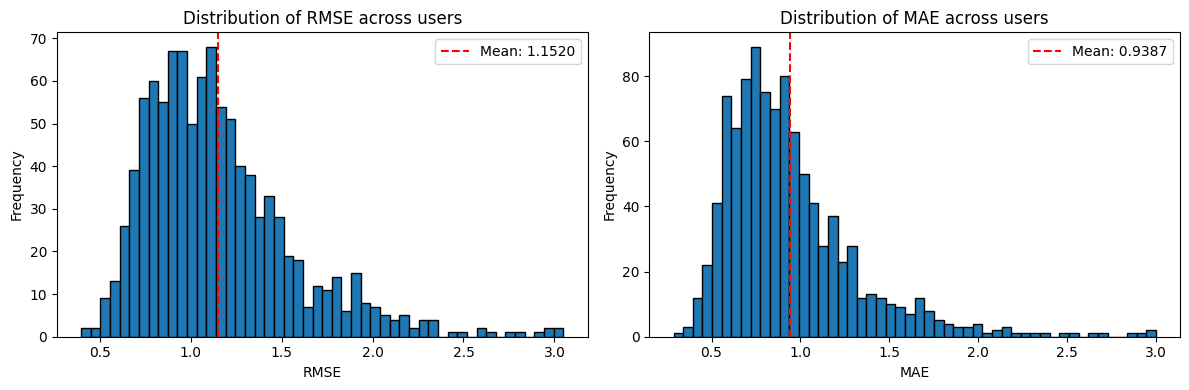

In [18]:
# evaluate_recommender.py
import numpy as np
import pandas as pd
import chromadb
from sklearn.model_selection import train_test_split
from collections import defaultdict
from app.database import MOVIES, RATINGS

# Configuration
CHROMA_PATH = "app/chroma_db"
TEST_SIZE = 0.2
RANDOM_STATE = 42
MIN_RATINGS_PER_USER = 5
TOP_N_USERS = 1000  # Evaluate only top N users with most ratings

# ---------------------------- 
# Load existing Chroma collection
# ---------------------------- 
_client = chromadb.PersistentClient(path=CHROMA_PATH)
_collection = _client.get_collection("movies")

print(f"✅ Loaded existing Chroma collection with {_collection.count()} embeddings")

# ---------------------------- 
# Train-Test Split
# ---------------------------- 
def create_train_test_split(ratings, test_size=0.2, min_ratings=5, top_n_users=1000):
    """
    Split ratings into train and test sets per user.
    Ensures each user has at least min_ratings total.
    Only evaluates on top_n_users with most ratings.
    """
    print(f"\n🔄 Splitting ratings data ({test_size*100}% test)...")
    
    # Filter users with enough ratings
    user_counts = ratings['userId'].value_counts()
    valid_users = user_counts[user_counts >= min_ratings].index
    
    # Select top N users with most ratings
    top_users = user_counts.nlargest(top_n_users).index
    selected_users = list(set(valid_users) & set(top_users))
    
    print(f"📊 Users with >={min_ratings} ratings: {len(valid_users)}")
    print(f"📊 Selecting top {top_n_users} users with most ratings")
    print(f"📊 Users in evaluation: {len(selected_users)}")
    
    ratings_filtered = ratings[ratings['userId'].isin(selected_users)]
    print(f"📊 Total ratings for selected users: {len(ratings_filtered)}")
    
    train_list = []
    test_list = []
    
    # Split per user to ensure representation
    for user_id in selected_users:
        user_ratings = ratings_filtered[ratings_filtered['userId'] == user_id]
        
        if len(user_ratings) < min_ratings:
            continue
            
        # Sort by timestamp to respect temporal order
        user_ratings = user_ratings.sort_values('timestamp')
        
        # Split: keep most recent as test
        split_idx = int(len(user_ratings) * (1 - test_size))
        train_user = user_ratings.iloc[:split_idx]
        test_user = user_ratings.iloc[split_idx:]
        
        # Ensure at least one rating in test
        if len(test_user) == 0 and len(user_ratings) > 1:
            train_user = user_ratings.iloc[:-1]
            test_user = user_ratings.iloc[-1:]
        
        if len(train_user) > 0 and len(test_user) > 0:
            train_list.append(train_user)
            test_list.append(test_user)
    
    train_ratings = pd.concat(train_list, ignore_index=True)
    test_ratings = pd.concat(test_list, ignore_index=True)
    
    print(f"✅ Train ratings: {len(train_ratings)}")
    print(f"✅ Test ratings: {len(test_ratings)}")
    print(f"✅ Final users in evaluation: {len(train_list)}\n")
    
    return train_ratings, test_ratings

# ---------------------------- 
# Recommendation Functions
# ---------------------------- 
def get_movie_embedding(movie_id: int):
    """Get average embedding for a movie from existing index"""
    res = _collection.get(
        where={"movie_id": str(movie_id)},
        include=["embeddings"]
    )
    
    if res is None:
        return None
    
    embeddings = res.get("embeddings")
    if embeddings is None or len(embeddings) == 0:
        return None
    
    return np.mean(np.array(embeddings), axis=0)

def genre_jaccard(g1, g2):
    """Calculate Jaccard similarity between genres"""
    if not g1 or not g2:
        return 0.0
    s1 = set(str(g1).split())
    s2 = set(str(g2).split())
    if len(s1 | s2) == 0:
        return 0.0
    return len(s1 & s2) / len(s1 | s2)

def predict_ratings_for_user(user_id, train_ratings, test_movie_ids):
    """
    Predict ratings for test movies based on training data.
    Returns dict of {movie_id: predicted_rating}
    """
    user_ratings = train_ratings[train_ratings["userId"] == user_id]
    liked = user_ratings[user_ratings["rating"] >= 3.5]
    
    if liked.empty:
        return {}
    
    rated_ids = set(user_ratings["movieId"])
    
    # Build user profile embedding from training data only
    embeddings = []
    weights = []
    for _, r in liked.iterrows():
        emb = get_movie_embedding(int(r["movieId"]))
        if emb is not None:
            embeddings.append(emb)
            weights.append(r["rating"] - 2.5)
    
    if not embeddings:
        return {}
    
    user_embedding = np.average(embeddings, axis=0, weights=weights)
    
    # Calculate average rating from liked movies (for baseline)
    avg_user_rating = liked["rating"].mean()
    
    # Get embeddings and calculate similarity for test movies
    predictions = {}
    
    for movie_id in test_movie_ids:
        if movie_id in rated_ids:
            continue
            
        movie_emb = get_movie_embedding(int(movie_id))
        if movie_emb is None:
            continue
        
        # Cosine similarity
        similarity = np.dot(user_embedding, movie_emb) / (
            np.linalg.norm(user_embedding) * np.linalg.norm(movie_emb)
        )
        
        # Genre bonus
        user_genres = MOVIES.loc[
            MOVIES["id"].isin(liked["movieId"]), "genres_parsed"
        ].str.cat(sep=" ")
        
        movie_genres = MOVIES.loc[MOVIES["id"] == movie_id, "genres_parsed"].values
        genre_score = genre_jaccard(
            movie_genres[0] if len(movie_genres) > 0 else "",
            user_genres
        )
        
        # Combined score (0 to 1 range)
        combined_score = 0.8 * similarity + 0.2 * genre_score
        
        # Convert similarity to rating prediction
        # Scale from user's average rating
        # If similarity is high (close to 1), predict higher than average
        # If similarity is low (close to 0 or negative), predict lower
        predicted_rating = avg_user_rating + (combined_score - 0.5) * 4
        
        # Clamp to valid rating range [0.5, 5.0]
        predicted_rating = np.clip(predicted_rating, 0.5, 5.0)
        
        predictions[movie_id] = predicted_rating
    
    return predictions

# ---------------------------- 
# Evaluation Metrics
# ---------------------------- 
def calculate_rmse_mae(predictions, actuals):
    """
    Calculate RMSE and MAE given predictions and actual ratings
    
    Args:
        predictions: dict of {movie_id: predicted_rating}
        actuals: dict of {movie_id: actual_rating}
    
    Returns:
        tuple of (rmse, mae, count)
    """
    common_movies = set(predictions.keys()) & set(actuals.keys())
    
    if len(common_movies) == 0:
        return None, None, 0
    
    errors = []
    abs_errors = []
    
    for movie_id in common_movies:
        pred = predictions[movie_id]
        actual = actuals[movie_id]
        
        error = pred - actual
        errors.append(error ** 2)
        abs_errors.append(abs(error))
    
    rmse = np.sqrt(np.mean(errors))
    mae = np.mean(abs_errors)
    
    return rmse, mae, len(common_movies)

def evaluate_recommender(train_ratings, test_ratings):
    """
    Evaluate recommendation system using RMSE and MAE
    """
    print("🔄 Evaluating recommender system...")
    
    # Get users who appear in both train and test
    test_users = test_ratings['userId'].unique()
    
    all_rmse = []
    all_mae = []
    all_counts = []
    evaluated_users = 0
    skipped_users = 0
    
    for user_id in test_users:
        # Get test items for this user
        test_user = test_ratings[test_ratings['userId'] == user_id]
        test_movie_ids = test_user['movieId'].tolist()
        
        # Create dict of actual ratings
        actuals = dict(zip(test_user['movieId'], test_user['rating']))
        
        # Predict ratings using only training data
        predictions = predict_ratings_for_user(
            user_id, train_ratings, test_movie_ids
        )
        
        if len(predictions) == 0:
            skipped_users += 1
            continue
        
        # Calculate metrics
        rmse, mae, count = calculate_rmse_mae(predictions, actuals)
        
        if rmse is None:
            skipped_users += 1
            continue
        
        all_rmse.append(rmse)
        all_mae.append(mae)
        all_counts.append(count)
        
        evaluated_users += 1
        
        if evaluated_users % 100 == 0:
            print(f"   Evaluated {evaluated_users} users...")
    
    # Aggregate metrics
    print(f"\n✅ Successfully evaluated: {evaluated_users} users")
    print(f"⚠️  Skipped: {skipped_users} users (no predictions)")
    print(f"📊 Total predictions made: {sum(all_counts)}")
    print(f"📊 Avg predictions per user: {np.mean(all_counts):.2f}")
    
    print("\n" + "="*60)
    print("EVALUATION RESULTS")
    print("="*60)
    
    overall_rmse = np.mean(all_rmse)
    overall_mae = np.mean(all_mae)
    std_rmse = np.std(all_rmse)
    std_mae = np.std(all_mae)
    median_rmse = np.median(all_rmse)
    median_mae = np.median(all_mae)
    
    results = {
        'rmse': {
            'mean': overall_rmse,
            'std': std_rmse,
            'median': median_rmse
        },
        'mae': {
            'mean': overall_mae,
            'std': std_mae,
            'median': median_mae
        }
    }
    
    print(f"RMSE: Mean={overall_rmse:.4f} (±{std_rmse:.4f})  Median={median_rmse:.4f}")
    print(f"MAE:  Mean={overall_mae:.4f} (±{std_mae:.4f})  Median={median_mae:.4f}")
    print("="*60)
    
    # Additional statistics
    print("\nDistribution of errors:")
    print(f"  RMSE - Min: {min(all_rmse):.4f}, Max: {max(all_rmse):.4f}")
    print(f"  MAE  - Min: {min(all_mae):.4f}, Max: {max(all_mae):.4f}")
    
    return results, {'rmse': all_rmse, 'mae': all_mae, 'counts': all_counts}

# ---------------------------- 
# Main Execution
# ---------------------------- 
def main():
    print("="*60)
    print("MOVIE RECOMMENDER EVALUATION (Using Existing Embeddings)")
    print("Metrics: RMSE and MAE")
    print("="*60)
    
    # Train-test split
    train_ratings, test_ratings = create_train_test_split(
        RATINGS, 
        test_size=TEST_SIZE,
        min_ratings=MIN_RATINGS_PER_USER,
        top_n_users=TOP_N_USERS
    )
    
    # Evaluate
    results, detailed_metrics = evaluate_recommender(
        train_ratings, 
        test_ratings
    )
    
    # Save detailed results
    results_df = pd.DataFrame(results).T
    results_df.to_csv("evaluation_results.csv")
    print(f"\n💾 Summary saved to: evaluation_results.csv")
    
    # Save per-user metrics for analysis
    per_user_df = pd.DataFrame(detailed_metrics)
    per_user_df.to_csv("per_user_metrics.csv", index=False)
    print(f"💾 Per-user metrics saved to: per_user_metrics.csv")
    
    # Create histogram of errors
    print("\n📊 Creating error distribution plots...")
    try:
        import matplotlib.pyplot as plt
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        axes[0].hist(detailed_metrics['rmse'], bins=50, edgecolor='black')
        axes[0].set_xlabel('RMSE')
        axes[0].set_ylabel('Frequency')
        axes[0].set_title('Distribution of RMSE across users')
        axes[0].axvline(results['rmse']['mean'], color='red', linestyle='--', 
                       label=f"Mean: {results['rmse']['mean']:.4f}")
        axes[0].legend()
        
        axes[1].hist(detailed_metrics['mae'], bins=50, edgecolor='black')
        axes[1].set_xlabel('MAE')
        axes[1].set_ylabel('Frequency')
        axes[1].set_title('Distribution of MAE across users')
        axes[1].axvline(results['mae']['mean'], color='red', linestyle='--',
                       label=f"Mean: {results['mae']['mean']:.4f}")
        axes[1].legend()
        
        plt.tight_layout()
        plt.savefig('error_distribution.png', dpi=300, bbox_inches='tight')
        print("💾 Error distribution plot saved to: error_distribution.png")
    except ImportError:
        print("⚠️  matplotlib not available, skipping plots")
    
    return results

if __name__ == "__main__":
    main()